## Question 3: Metallicity

**Summary:** *The radial metallicity relation is a function that describes the change of metallicity - here the gas phase metallicity A(O) = log10(NO/NH) + 12 - along the galactocentric cylindrical radius RGal.. Understanding the radial metallicity gradient in galaxies provides critical insights into their formation and evolutionary processes, such as inside-out formation, gas accretion, outflows, and radial migration. A lot of work has been done through observational studies (e.g. Ho et al., 2017, ApJ, 846, 39) and a few simulations (e.g. Grand et al., 2016, MNRAS, 460, 94), but more works needs to be done to understand the radial metallicity gradient! Your colleague has just finished an exciting cosmological simulation that traces the gas phase metallicity for a Milky Way analogue, that is, a spiral galaxy. They have limited the simulation data to the positions (x, y, z) of the innermost gas particles (RGal. < 25 kpc) and their gas phase metallicity A(O) and uploaded them as a FITS file for you here: https://github.com/svenbuder/astr4004_2025_week8/blob/main/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits*

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from matplotlib import patches
from matplotlib.colors import LogNorm

In [21]:
# Import fits data
hdul = fits.open('../data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')
data = hdul[1].data
header = hdul[1].header
hdul.close()

metal_pd = Table(data)
metal_pd = metal_pd.to_pandas()

display(metal_pd.head())

,x,y,z,A_O
0,10.020546,-15.421509,-3.241711,8.428943
1,-13.487837,5.663507,-0.802306,8.671107
2,6.642289,-0.138942,-0.585961,8.891596
3,0.203939,4.112373,-0.147622,8.977195
4,-20.824045,6.971037,-1.758061,8.326950


In [57]:
# Create the cylindrical radius
metal_pd['radius'] = np.sqrt(metal_pd['x']**2 + metal_pd['y']**2 + metal_pd['z']**2) # Do we need to have the z here as well?

/var/folders/p7/q8wsc25n16d1867zxd46f3b80000gn/T/ipykernel_82013/4076371368.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


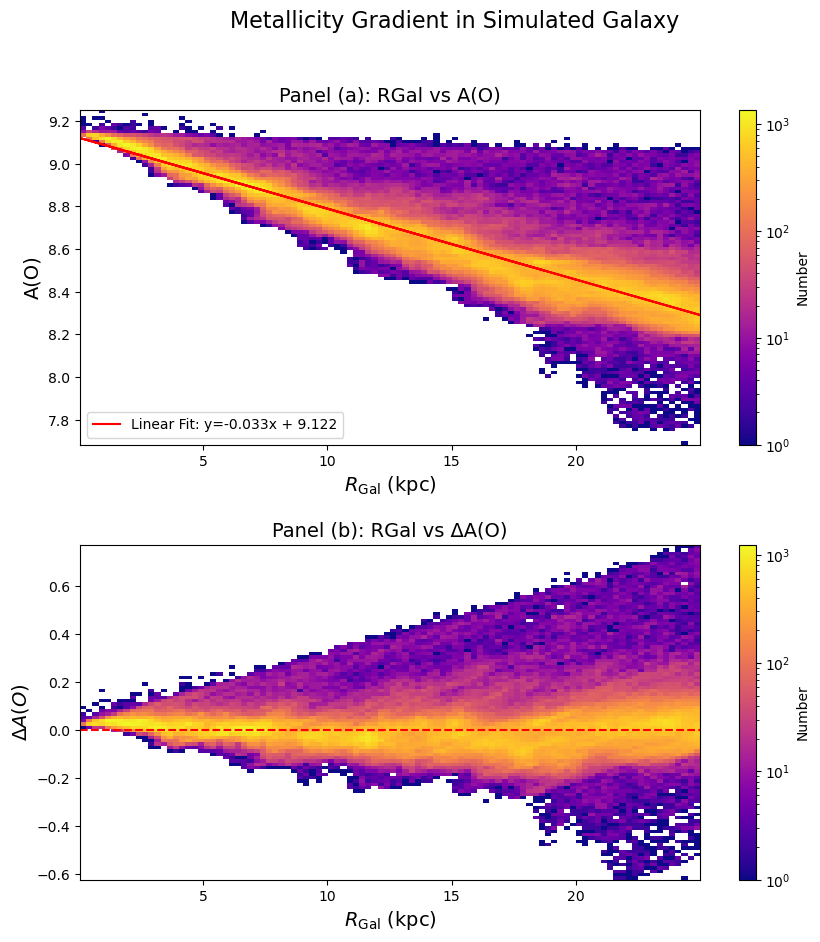

In [ ]:
"""Plot a 2-panel figure:
– (a) Logarithmic density plot of RGal. vs. A(O), with a linear fit and legend.
– (b) Residuals of the fit, RGal. vs. ΔA(O)."""

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Metallicity Gradient in Simulated Galaxy', fontsize=16)

# Panel (a): Logarithmic density plot
h1 = ax1.hist2d(metal_pd['radius'],metal_pd['A_O'],bins = 100,norm = LogNorm(), cmap='plasma')
cbar = plt.colorbar(h1[-1], ax=ax1, label = 'Number')
ax1.set_xlabel(r'$R_\text{Gal}$ (kpc)', fontsize=14)
ax1.set_ylabel('A(O)', fontsize=14)
ax1.legend()
ax1.set_title('Panel (a): RGal vs A(O)', fontsize=14)
# Linear fit weighted evenly
coeffs = np.polyfit(metal_pd['radius'], metal_pd['A_O'], 1)
fit_line = np.poly1d(coeffs)
ax1.plot(metal_pd['radius'], fit_line(metal_pd['radius']), color='red', label=f'Linear Fit: y={coeffs[0]:.3f}x + {coeffs[1]:.3f}')
ax1.legend(loc='lower left')

# Panel (b): Residuals of the fit
residuals = metal_pd['A_O'] - fit_line(metal_pd['radius'])
h2 = ax2.hist2d(metal_pd['radius'], residuals, bins=100, norm=LogNorm(), cmap='plasma')
cbar = plt.colorbar(h2[-1], ax=ax2, label='Number')
#ax2.scatter(metal_pd['radius'], residuals, c='green', label='Residuals', alpha=0.5)
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel(r'$R_\text{Gal}$ (kpc)', fontsize=14)
ax2.set_ylabel(r'$\Delta A(O)$', fontsize=14)
ax2.set_title('Panel (b): RGal vs ΔA(O)', fontsize=14)
plt.show()

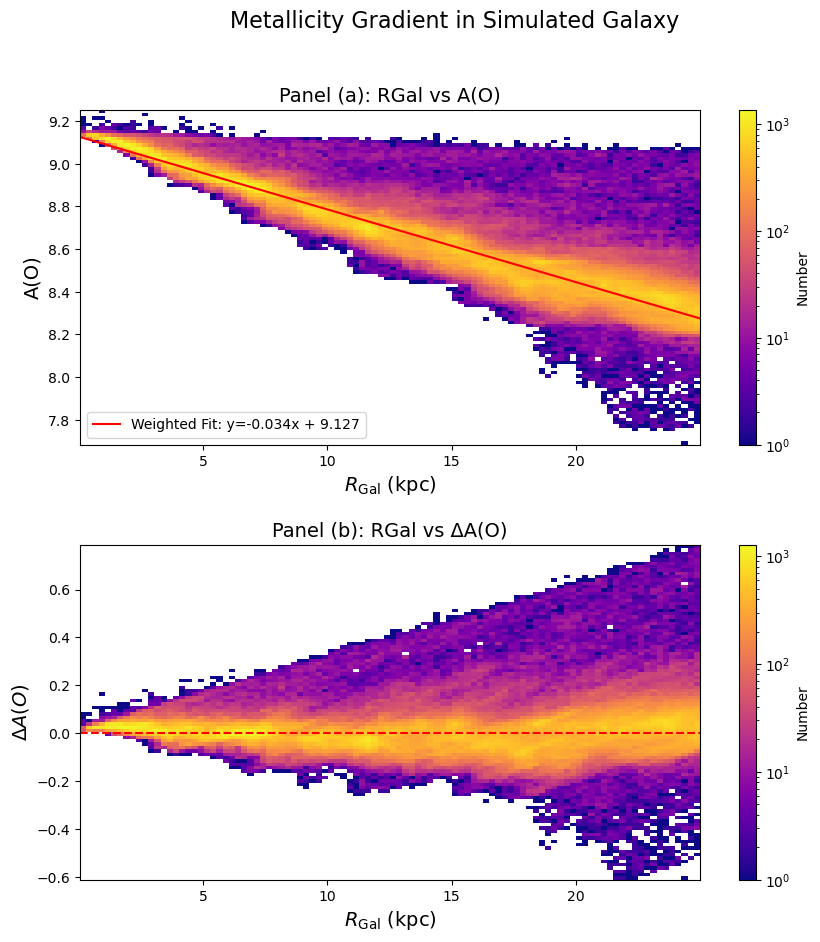

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Metallicity Gradient in Simulated Galaxy', fontsize=16)

# Panel (a): Logarithmic density plot
h1 = ax1.hist2d(metal_pd['radius'], metal_pd['A_O'], bins=100, norm=LogNorm(), cmap='plasma')
cbar = plt.colorbar(h1[-1], ax=ax1, label='Number')
ax1.set_xlabel(r'$R_\text{Gal}$ (kpc)', fontsize=14)
ax1.set_ylabel('A(O)', fontsize=14)
ax1.set_title('Panel (a): RGal vs A(O)', fontsize=14)

# --- Weighted linear fit using 2D histogram ---
# Extract histogram data
counts, xedges, yedges = np.histogram2d(metal_pd['radius'], metal_pd['A_O'], bins=100)

# Bin centers
xcenters = 0.5 * (xedges[1:] + xedges[:-1])
ycenters = 0.5 * (yedges[1:] + yedges[:-1])

# Flatten grid
xx, yy = np.meshgrid(xcenters, ycenters, indexing='ij')
xvals = xx.flatten()
yvals = yy.flatten()
weights = counts.flatten()

# Keep only bins with nonzero counts
mask = weights > 0
xvals = xvals[mask]
yvals = yvals[mask]
weights = weights[mask]

# Weighted linear fit
coeffs = np.polyfit(xvals, yvals, deg=1, w=weights)
fit_line = np.poly1d(coeffs)

# Plot fit line
x_sorted = np.sort(metal_pd['radius'])
ax1.plot(x_sorted, fit_line(x_sorted), color='red',
         label=f'Weighted Fit: y={coeffs[0]:.3f}x + {coeffs[1]:.3f}')
ax1.legend(loc='lower left')

# Panel (b): Residuals of the fit
residuals = metal_pd['A_O'] - fit_line(metal_pd['radius'])
h2 = ax2.hist2d(metal_pd['radius'], residuals, bins=100, norm=LogNorm(), cmap='plasma')
cbar = plt.colorbar(h2[-1], ax=ax2, label='Number')
ax2.axhline(0, color='red', linestyle='--')
ax2.set_xlabel(r'$R_\text{Gal}$ (kpc)', fontsize=14)
ax2.set_ylabel(r'$\Delta A(O)$', fontsize=14)
ax2.set_title('Panel (b): RGal vs ΔA(O)', fontsize=14)

plt.show()
